In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import yaml


/Users/kreckel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


fiberid
spectrographid
blockid
finblock
targettype
ifulabel
finifu
xpmm
ypmxx
ringnum
fibstatus


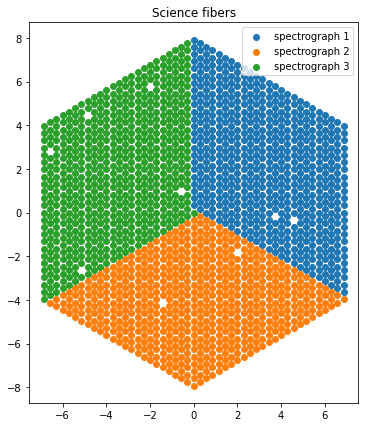

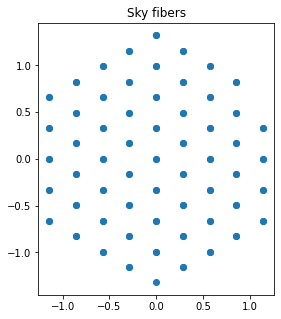

In [375]:
# set up the fiber mapping
# yaml file is this one:
# https://github.com/sdss/lvmcore/blob/master/metrology/LVM_SAIT_fibermap.yaml

stream = open('LVM_SAIT_fibermap.yaml', 'r')
fibermap = yaml.load(stream)
stream.close()

fibers=fibermap['fibers']

tab = {}

# load the schema into a dictionary
for ii,key in enumerate(fibermap['schema']):
    print(key['name'])
    tab[key['name']] = np.array([item[ii] for item in fibers])


sky = (tab['targettype'] == 'SKY')
science = (tab['targettype'] == 'science')

science1 = (tab['targettype'] == 'science') & (tab['spectrographid']==1) & (tab['fibstatus']==0)
science2 = (tab['targettype'] == 'science') & (tab['spectrographid']==2) & (tab['fibstatus']==0)
science3 = (tab['targettype'] == 'science') & (tab['spectrographid']==3) & (tab['fibstatus']==0)

plt.figure(figsize=(7,7))
plt.scatter(tab['xpmm'][science1],tab['ypmxx'][science1],label='spectrograph 1')
plt.scatter(tab['xpmm'][science2],tab['ypmxx'][science2],label='spectrograph 2')
plt.scatter(tab['xpmm'][science3],tab['ypmxx'][science3],label='spectrograph 3')
plt.legend()
plt.title('Science fibers')

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

plt.figure(figsize=(5,5))
plt.scatter(tab['xpmm'][sky],tab['ypmxx'][sky],label='sky')
plt.title('Sky fibers')

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

In [486]:
# read in the 'homogenized RSS', 'hobject', which are wavelength resampled RSS, with a common wavelength vector for each fiber
# https://wiki.sdss.org/display/LVM/Data+Reduction+Pipeline+development+and+testing
#
# data is here: 
# https://data.sdss5.org/sas/sdsswork/lvm/sandbox/sait_test/

# SAIT run
# only r and z 
file_ID = '00000207' # M42
#file_ID =  '00000208' # M42 + 30'
#file_ID =  '00000209' # 30 Dor
# '00000210' # 30 Dor + 30'
#file_ID =  '00000211' # M104
#file_ID = '00000212' # M104

# read in the r channel
hdul = fits.open('lvm-hobject-r1-'+file_ID+'.fits')
r1 = hdul[0].data
r1_hdr = hdul[0].header
r1_err = hdul[2]
hdul.close()
wl_r1 = np.arange(0,r1_hdr['NAXIS1'],1)*r1_hdr['CDELT1'] + r1_hdr['CRVAL1']
#r1_hdr

# read in the z channel
hdul = fits.open('lvm-hobject-z1-'+file_ID+'.fits')
z1 = hdul[0].data
z1_hdr = hdul[0].header
z1_err = hdul[2]
hdul.close()
wl_z1 = np.arange(0,z1_hdr['NAXIS1'],1)*z1_hdr['CDELT1'] + z1_hdr['CRVAL1']
#z1_hdr

# select the subset of fibers that have extracted spectra
# should match the fibers that had light during the SAIT run
mask1 = (tab['spectrographid']==1) & (tab['targettype']!='standard') & (tab['fibstatus']==0)

# pick out just the science fibers
sci = (tab['targettype'][mask1]=='science')

# sanity check that the fiber mapping agrees with the number of fibers in the RSS file
print('size of the RSS file: ',r1.shape,z1.shape)
print('size of the fiber mapping: ',np.sum(mask1))
print('number of science fibers: ',np.sum(sci))


size of the RSS file:  (638, 2061) (638, 2331)
size of the fiber mapping:  638
number of science fibers:  598


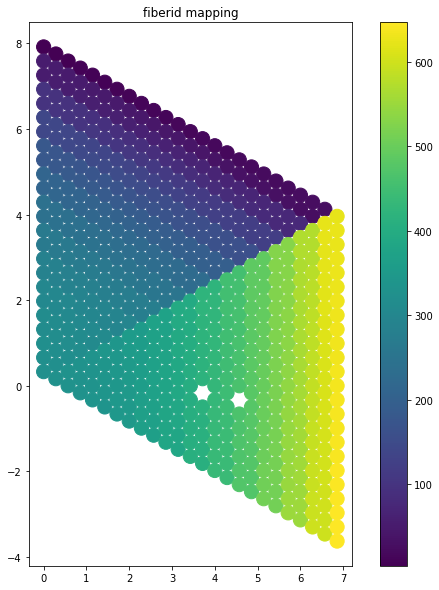

In [487]:
plt.figure(figsize=(10,10))
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c =tab['fiberid'][mask1][sci] ,s=200)
plt.title('fiberid mapping')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

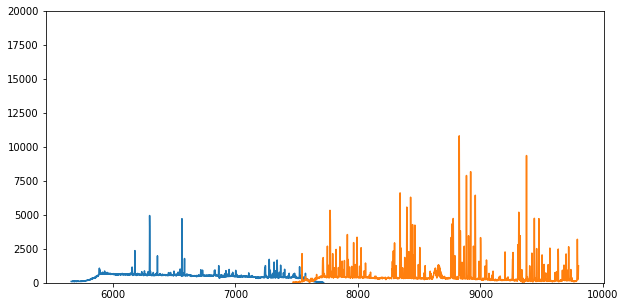

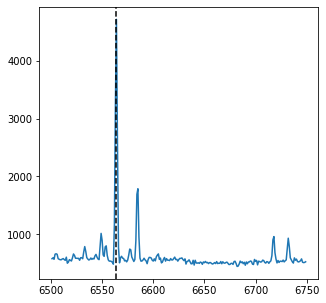

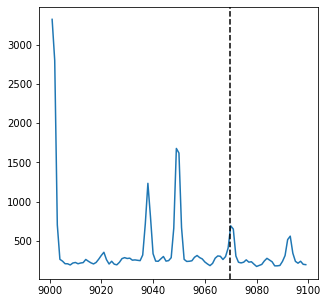

In [488]:
# plot some spectra to look at
pick_a_fiber = 10 #587#10

# for Orion
if file_ID == '00000207':
    wl_shift_vel = 20. # figure this out by eye
# for 30 Dor
elif file_ID == '00000209':
    wl_shift_vel = 250. # figure this out by eye
else:
    wl_shift_vel = 0.

    
plt.figure(figsize=(10,5))
plt.plot(wl_r1,r1[pick_a_fiber,:])
plt.plot(wl_z1,z1[pick_a_fiber,:])
plt.ylim(0,20000)

fig = plt.figure(figsize=(5,5)) 
iis = np.where((wl_r1 > 6500) & (wl_r1 < 6750))[0]
plt.plot(wl_r1[iis],r1[pick_a_fiber,iis])
plt.axvline(6563+wl_shift_vel/3e5*6563.,linestyle='dashed',color='k')
    
plt.figure(figsize=(5,5))
iis = np.where((wl_z1 > 9000) & (wl_z1 < 9100))[0]
plt.plot(wl_z1[iis],z1[pick_a_fiber,iis])
plt.axvline(9069+wl_shift_vel/3e5*9069.,linestyle='dashed',color='k')

/Users/kreckel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10


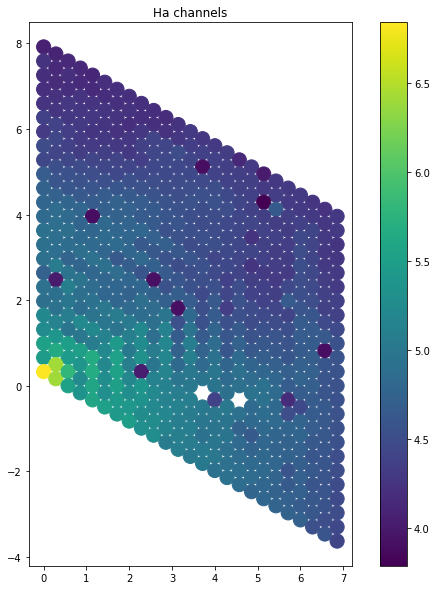

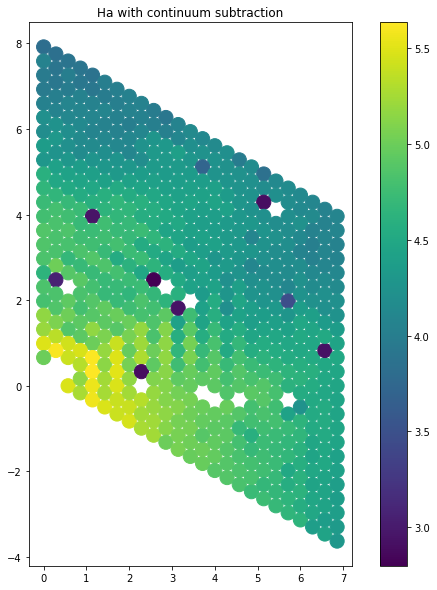

In [489]:
# Halpha
wl_ha = (wl_r1 > 6560 + wl_shift_vel/3e5*6560) & (wl_r1 < 6570+ wl_shift_vel/3e5*6570)
#wl_ha = (wl_r1 > 6550) & (wl_r1 < 6580)
iis_ha = np.where(wl_ha)[0]
ha = np.sum(r1[:,iis_ha],axis=1)

wl_ha_cont = (wl_r1 > 6600+ wl_shift_vel/3e5*6600) & (wl_r1 < 6610+ wl_shift_vel/3e5*6610)
#wl_ha_cont = (wl_r1 > 6600) & (wl_r1 < 6630)
iis_ha_cont = np.where(wl_ha_cont)[0]
ha_cont = np.sum(r1[:,iis_ha_cont],axis=1)


plt.figure(figsize=(10,10))
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha[sci]),s=200)
plt.title('Ha channels')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()


plt.figure(figsize=(10,10))
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha[sci]-ha_cont[sci]),s=200)
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.title('Ha with continuum subtraction')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

if 0:
    #print(np.where(ha-ha_cont > 0)[0])
    #print(np.where(np.log10(ha[sci]) < 4.0)[0])
    tmp = tab['finifu'][mask1][sci]
    low = np.where(np.log10(ha[sci]) < 4.0)[0]
    low2 = np.where((ha[sci]-ha_cont[sci]) < 0.0)[0]
    print("fiber #s (finifu) with unusually low ha channel fluxes (S1-#): ",tmp[low])
    print("fiber #s (finifu) with negative ha continuum subtracted fluxes (S1-#): ",tmp[low2])

    print('basically all at the edge of the slit block')

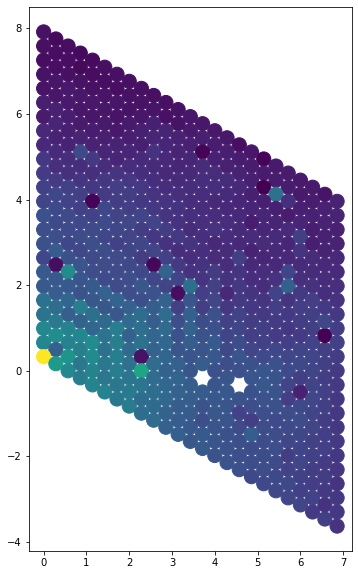

In [427]:
# [SIII]9069

wl_siii9068 = (wl_z1 > 9065+ wl_shift_vel/3e5*9065) & (wl_z1 < 9075+ wl_shift_vel/3e5*9075)
#wl_siii9068 = (wl_z1 > 9000) & (wl_z1 < 9100)
iis_siii9068 = np.where(wl_siii9068)[0]
siii9068 = np.sum(z1[:,iis_siii9068],axis=1)


plt.figure(figsize=(10,10))
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci],c=np.log10(siii9068[sci]),s=200)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

[ 65 221 232 265 266 298 299 300 301 331 332 351 365 366 398 494 499 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 565 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588]


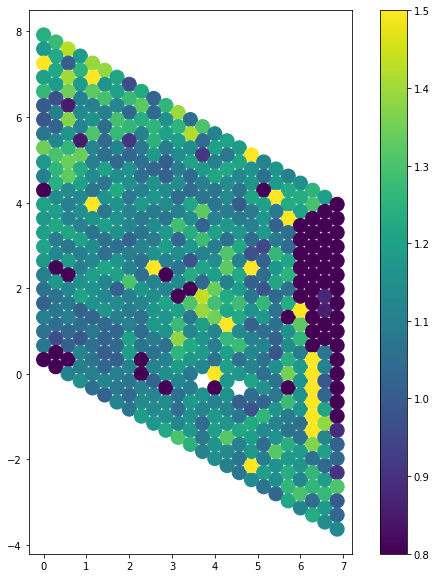

In [442]:
# SII doublet

wl_sii1 = (wl_r1 > 6715+ wl_shift_vel/3e5*6715) & (wl_r1 < 6725+ wl_shift_vel/3e5*6725)
iis_sii1 = np.where(wl_sii1)[0]
sii1 = np.sum(r1[:,iis_sii1],axis=1)

wl_sii2 = (wl_r1 > 6730+ wl_shift_vel/3e5*6730) & (wl_r1 < 6740+ wl_shift_vel/3e5*6740)
iis_sii2 = np.where(wl_sii2)[0]
sii2 = np.sum(r1[:,iis_sii2],axis=1)


wl_sii_cont = (wl_r1 > 6700+ wl_shift_vel/3e5*6700) & (wl_r1 < 6710+ wl_shift_vel/3e5*6710)
iis_sii_cont = np.where(wl_sii_cont)[0]
sii_cont = np.sum(r1[:,iis_sii_cont],axis=1)


plt.figure(figsize=(10,10))
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = (sii1[sci]-sii_cont[sci])/(sii2[sci]-sii_cont[sci]),s=200,vmin=0.8,vmax=1.5)

plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

print(np.where((sii1[sci]-sii_cont[sci])/(sii2[sci]-sii_cont[sci]) < 0.8)[0])


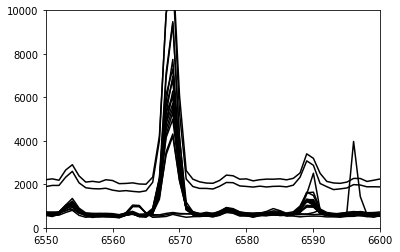

In [389]:
# in case you want to visualize a bunch of the spectra overlaid
sci = (tab['targettype'][mask1]=='science')

for i in np.arange(70,90):#np.sum(mask1)):
    plt.plot(wl_r1,r1[i,:],color='k')
    plt.xlim(6550,6600)
    plt.ylim(0,10000)
#    plt.xlim(6280,6320)


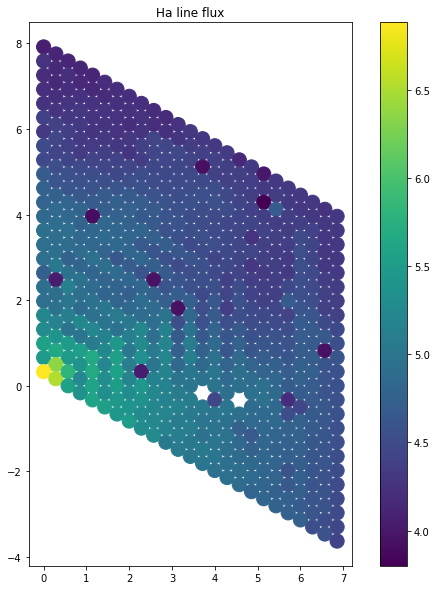

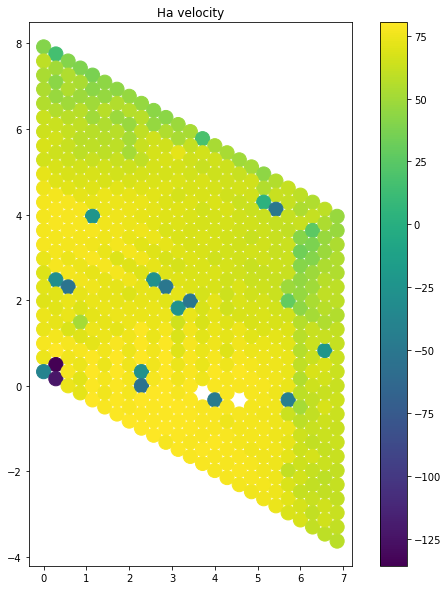

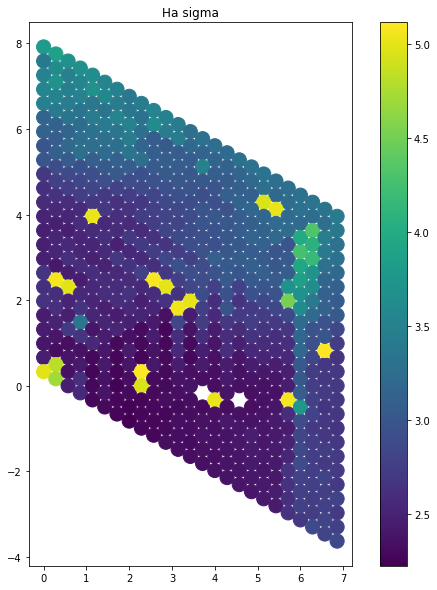

In [473]:
# initial DAP run from Sebastian
# downloaded from slack

hdul = fits.open('lvm-hobject-r1-00000207.flux_elines.fits')
#hdul = fits.open('lvm-hobject-r1-00000208.flux_elines.fits') # this observation was 30' offset, so not sure what it targets
r1_fluxes = hdul[0].data
r1_fluxes_hdr = hdul[0].header
hdul.close()

ha = r1_fluxes[124,:]

plt.figure(figsize=(10,10))
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha[sci]),s=200)
plt.title('Ha line flux')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

ha_vel = r1_fluxes[316,:]

plt.figure(figsize=(10,10))
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = (ha_vel[sci]),s=200)
plt.title('Ha velocity')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

ha_sig = r1_fluxes[508,:]

plt.figure(figsize=(10,10))
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = (ha_sig[sci]),s=200)
plt.title('Ha sigma')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

In [474]:
r1_fluxes_hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  638                                                  
NAXIS2  =                 1536                                                  
EXTEND  =                    T                                                  
V_ARCHON= '0.8.0   '                                                            
FILENAME= 'sdR-s-r1-00000207.fits.gz' / File basename                           
EXPOSURE=                  207 / Exposure number                                
SPEC    = 'sp1     '           / Spectrograph name                              
OBSERVAT= 'LCO     '           / Observatory                                    
OBSTIME = '2023-03-08T00:39:44.019' / Start of the observation                  
MJD     =                600

In [457]:
r1_fluxes.shape

(1536, 638)

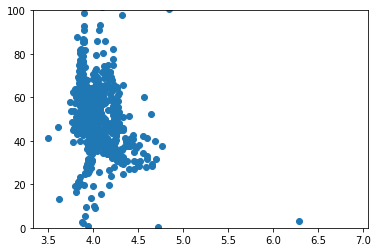

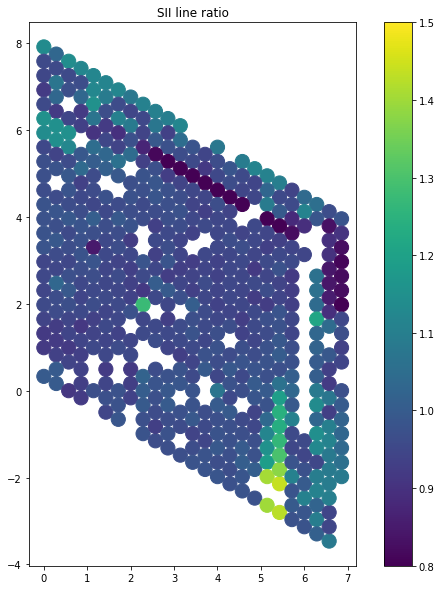

In [478]:
# looking at the SII density diagnostic

sii1 = r1_fluxes[127,:]
sii1_e = r1_fluxes[895,:]
sii2 = r1_fluxes[128,:]
sii2_e = r1_fluxes[896,:]

good = sci & (sii1/sii1_e > 30) & (sii2/sii2_e > 30)
sii_ratio = sii1/sii2

plt.scatter(np.log10(sii1),sii1/sii1_e)
plt.ylim(0,100)

plt.figure(figsize=(10,10))
#plt.scatter(tab['xpmm'][mask1][sci],tab['ypmxx'][mask1][sci], c = np.log10(ha_cont[sci]),s=200)
plt.scatter(tab['xpmm'][mask1][good],tab['ypmxx'][mask1][good], c = (sii_ratio[good]),s=200,vmin=0.8,vmax=1.5)
plt.title('SII line ratio')
plt.colorbar()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()